In [1]:
import psycopg2
from sqlalchemy import create_engine, Column, Integer, String, Float, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
import re
from __future__ import print_function

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf

In [3]:
dbname = 'restaurants'
username = 'andylane'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
con = None
con = psycopg2.connect(database = "restaurants", user = "andylane")
Session = sessionmaker(bind=engine)
session = Session()

postgres://andylane@localhost/restaurants


/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/sqlalchemy/dialects/__init__.py:34: SADeprecationWarning: The SQLAlchemy PostgreSQL dialect has been renamed from 'postgres' to 'postgresql'. The new URL format is postgresql[+driver]://<user>:<pass>@<host>/<dbname>
  module = __import__('sqlalchemy.dialects.%s' % (dialect, )).dialects


In [4]:
from menusights_aux import *

In [5]:
recipes = pd.read_sql("recipes", engine)

## Get recipe names into a vector

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

In [7]:
def tokenize_and_stem(title):
    stemmer = SnowballStemmer("english")
    stemmed_titles = []
    new_title=[]
    for word in nltk.word_tokenize(title):
        new_title.append(stemmer.stem(word))
    stemmed_titles.extend(new_title)
    return " ".join([i for i in stemmed_titles])

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
tokenized_names = [tokenize_and_stem(i) for i in (recipes["name"])]

In [84]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0.0003)

In [85]:
a = vectorizer.fit_transform(tokenized_names)

In [12]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [13]:
def chol_to_percentile(vector, operate_on):
    v = [i for i in vector if i != 0]
    pctvector = []
    pct75 = np.percentile(v, 75)
    pct50 = np.percentile(v, 50)
    pct20 = np.percentile(v, 20)
    print(pct75)
    print(pct50)
    print(pct20)
    for index, i in enumerate(operate_on):
        if i > pct75:
            pctvector.append("vhigh")
        elif i > pct50:
            pctvector.append("high")
        elif i > pct20:
            pctvector.append("med")
        else:
            pctvector.append("low")
    return pctvector

In [14]:
cholcat = chol_to_percentile(recipes["cholesterol"], recipes["cholesterol"])

124.0
81.0
47.0


In [15]:
# produces an array with mutual information (weights?) between individual words/n-grams in recipe names and cholesterol information
mi = mutual_info_regression(a, recipes["cholesterol"])
mi /= np.max(mi)

In [71]:
len(np.array(tokenized_names)[informative_words])

427

In [127]:
# Returns indices of columns with MI value greater than e.g. 0.02. Can be used for re
informative_words = np.array([(index) for index, i in enumerate(mi) if i>0.000002])
# return word vector array with uninformative words removeds
culled_array = a.toarray()[:,informative_words]

In [128]:
import cPickle as pkl

In [129]:
ground_truth_x =[]
ground_truth_y =[]
for item in pkl.load(open("groundtruth.pkl", "rb")):
    ground_truth_x.append(item["item_name"])
    ground_truth_y.append(item["nf_cholesterol"])

In [130]:
for item in pkl.load(open("groundtruth2.pkl", "rb")):
        ground_truth_x.append(item["item_name"])
        ground_truth_y.append(item["nf_cholesterol"])

In [131]:
for item in pkl.load(open("groundtruth3.pkl", "rb")):
        ground_truth_x.append(item["item_name"])
        ground_truth_y.append(item["nf_cholesterol"])


In [132]:
tokenized_names_ground_truth = [tokenize_and_stem(i) for i in (ground_truth_x)]
# Puts words from new ground truth set into matrix from training set
ground_truth_vectorized = vectorizer.transform(tokenized_names_ground_truth)
ground_truth_vectorized_culled_array = ground_truth_vectorized.toarray()[:,informative_words]

In [133]:
for index, i in enumerate(ground_truth_y):
    if i == None:
        ground_truth_y[index] = 0

In [134]:
mask = [index for (index, item) in enumerate(ground_truth_y) if item !=0]

In [135]:
masked_ground_truth = []
for i,j in enumerate(ground_truth_y):
    if i in mask:
        masked_ground_truth.append(j)
        
masked_ground_truth_vectnames = []
for i,j in enumerate(ground_truth_vectorized_culled_array):
    if i in mask:
        masked_ground_truth_vectnames.append(j)


### Linear SVM

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, datasets

X_train = culled_array[:-200]
#y_train = recipes["cholesterol"]
y_train = cholcat[:-200]
X=X_train
y=y_train

X_test = culled_array[-200:]
y_test = cholcat[-200:]

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1  # SVM regularization parameter
lin_svc = svm.LinearSVC(C=C).fit(X_train, y_train)

124.0
81.0
47.0


/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


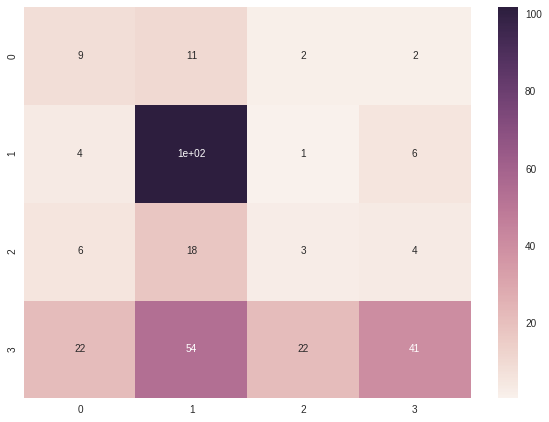

In [137]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(chol_to_percentile(recipes["cholesterol"], masked_ground_truth), \
                      lin_svc.predict(masked_ground_truth_vectnames))

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [138]:
lin_svc.score(masked_ground_truth_vectnames, chol_to_percentile(recipes["cholesterol"], masked_ground_truth))

124.0
81.0
47.0


0.50488599348534202

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


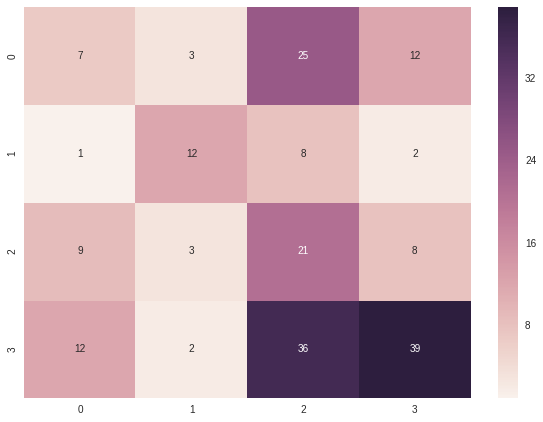

In [126]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, lin_svc.predict(X_test))

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

### Polynomial SVM

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, datasets

X_train = culled_array[200:]
#y_train = recipes["cholesterol"]
y_train = cholcat[200:]
X=X_train
y=y_train

X_test = culled_array[:200]
y_test = cholcat[:200]

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1  # SVM regularization parameter
poly_svc = svm.SVC(kernel='poly', degree=2, C=C).fit(X, y)
#lin_svc = svm.LinearSVC(C=C).fit(X_train, y_train)

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


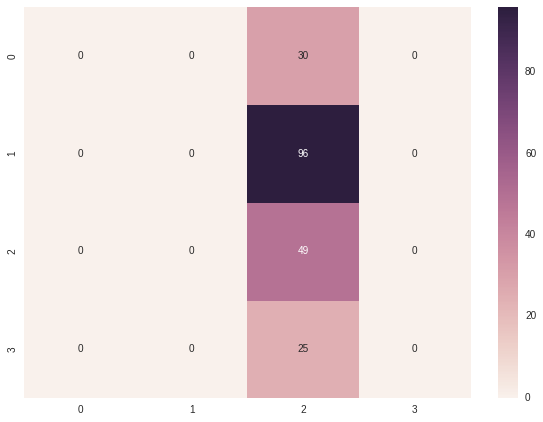

In [32]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, poly_svc.predict(X_test))

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [33]:
poly_svc.score(masked_ground_truth_vectnames, chol_to_percentile(recipes["cholesterol"], masked_ground_truth))

124.0
81.0
47.0


0.10097719869706841

#### Well, that looks even worse. Try an RBF kernel.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, datasets

X_train = culled_array[200:]
#y_train = recipes["cholesterol"]
y_train = cholcat[200:]
X=X_train
y=y_train

X_test = culled_array[:200]
y_test = cholcat[:200]

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1  # SVM regularization parameter
rbf_svc = svm.SVC(kernel='rbf', gamma=1, C=C).fit(X, y)

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


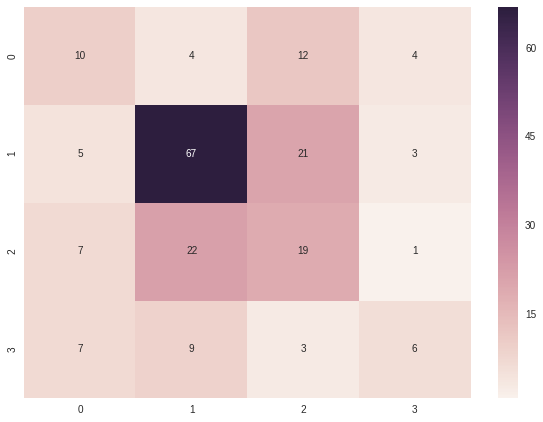

In [35]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, rbf_svc.predict(X_test))

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

124.0
81.0
47.0


/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


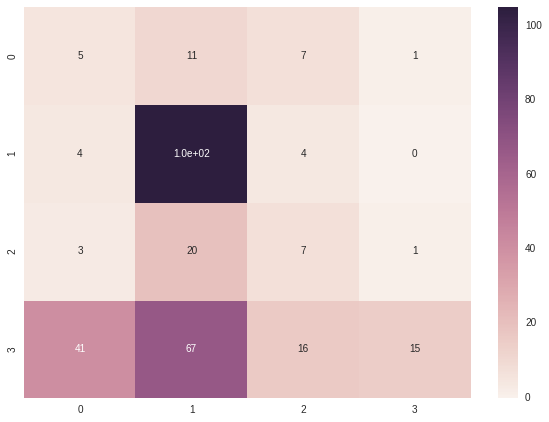

In [36]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(chol_to_percentile(recipes["cholesterol"], masked_ground_truth), rbf_svc.predict(masked_ground_truth_vectnames))

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [37]:
poly_svc.score(masked_ground_truth_vectnames, chol_to_percentile(recipes["cholesterol"], masked_ground_truth))

124.0
81.0
47.0


0.10097719869706841

### NuSVC

In [41]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))
np.random.seed(0)
# X = np.random.randn(300, 2)
# Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
nusvc = svm.NuSVC().fit(X, y)

Automatically created module for IPython interactive environment


124.0
81.0
47.0


/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


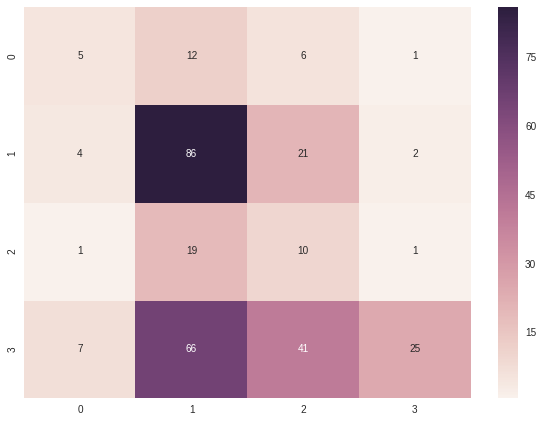

In [42]:
cm = confusion_matrix(chol_to_percentile(recipes["cholesterol"], masked_ground_truth), nusvc.predict(masked_ground_truth_vectnames))
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [43]:
nusvc.score(masked_ground_truth_vectnames, chol_to_percentile(recipes["cholesterol"], masked_ground_truth))

124.0
81.0
47.0


0.41042345276872966

### SGDClassifier

In [52]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))
np.random.seed(0)
# X = np.random.randn(300, 2)
# Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
sgd = linear_model.SGDClassifier('log').fit(X, y)

Automatically created module for IPython interactive environment


124.0
81.0
47.0


/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


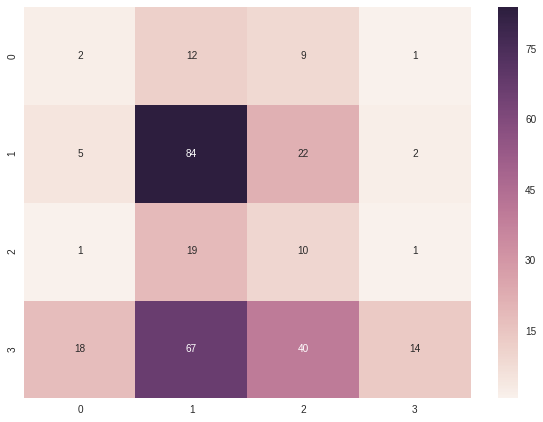

In [53]:
cm = confusion_matrix(chol_to_percentile(recipes["cholesterol"], masked_ground_truth), sgd.predict(masked_ground_truth_vectnames))
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [54]:
sgd.score(masked_ground_truth_vectnames, chol_to_percentile(recipes["cholesterol"], masked_ground_truth))

124.0
81.0
47.0


0.35830618892508143

In [51]:
sgd.decision_function(masked_ground_truth_vectnames[0])

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[-1.5226394 , -0.43078736, -1.3313685 , -2.4551243 ]])

In [55]:
sgd.predict_proba(masked_ground_truth_vectnames[0])

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.17555163,  0.43454049,  0.28061909,  0.10928879]])

In [117]:
sgd.coef_[:,332]

array([ 0.34852062, -3.74293418, -2.2272293 ,  3.39133993])

In [118]:
sgd.coef_[:,331]

array([-1.14794437,  2.77932922, -1.33370815, -0.85053358])

In [109]:
list(np.array(vectorizer.get_feature_names())[informative_words]).index("shrimp")

332